In [1]:
import os
import numpy as np
import torch
from PIL import Image
import torch.utils.data

In [2]:
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]        
        

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            #print("xmin={}, ymin={}, xmax={}, ymax={}".format(xmin, ymin, xmax, ymax) )
            

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        
#         print("type(boxes)", type(boxes), boxes.shape)
#         print("type(labels)", type(labels), labels.shape)
#         print("type(image_id)", type(image_id), image_id.shape)
#         print("type(area)", type(area), area.shape)
#         print("type(iscrowd)", type(iscrowd), iscrowd.shape)
        

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)    

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #print("in_features", in_features)
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [4]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []    
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device", device)

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)    
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

SAVED_PATH = './k_model_2019.06.25.nn.pt'
# save the target path.
torch.save(model.state_dict(), SAVED_PATH)
print("model saved.")

device cuda
Epoch: [0]  [ 0/60]  eta: 0:01:37  lr: 0.000090  loss: 1.1297 (1.1297)  loss_classifier: 0.9294 (0.9294)  loss_box_reg: 0.1757 (0.1757)  loss_objectness: 0.0131 (0.0131)  loss_rpn_box_reg: 0.0115 (0.0115)  time: 1.6273  data: 0.0461  max mem: 2924
Epoch: [0]  [10/60]  eta: 0:00:25  lr: 0.000936  loss: 0.7451 (0.8356)  loss_classifier: 0.5657 (0.5593)  loss_box_reg: 0.2670 (0.2472)  loss_objectness: 0.0131 (0.0160)  loss_rpn_box_reg: 0.0115 (0.0130)  time: 0.5084  data: 0.0373  max mem: 4096
Epoch: [0]  [20/60]  eta: 0:00:17  lr: 0.001783  loss: 0.4785 (0.6230)  loss_classifier: 0.2588 (0.3924)  loss_box_reg: 0.1933 (0.2056)  loss_objectness: 0.0105 (0.0143)  loss_rpn_box_reg: 0.0095 (0.0108)  time: 0.3871  data: 0.0345  max mem: 4641
Epoch: [0]  [30/60]  eta: 0:00:12  lr: 0.002629  loss: 0.2191 (0.4834)  loss_classifier: 0.1030 (0.2862)  loss_box_reg: 0.1078 (0.1747)  loss_objectness: 0.0050 (0.0120)  loss_rpn_box_reg: 0.0063 (0.0106)  time: 0.3687  data: 0.0301  max mem: 4

In [6]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):    
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))    
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [7]:
modelsaved = get_model_instance_segmentation(num_classes)
modelsaved.load_state_dict( torch.load(SAVED_PATH))
modelsaved.eval()
modelsaved.to(device)
img, _ = dataset_test[0]
# put the model in evaluation mode
modelsaved.eval()
with torch.no_grad():
    prediction = modelsaved([img.to(device)])

{'boxes': tensor([[355.1906,  71.6545, 441.7130, 336.1586],
        [213.1061,  66.5206, 307.9633, 340.0617],
        [127.3263,  48.9295, 202.5004, 226.9364],
        [290.2821,  48.7643, 349.8939, 228.1489],
        [273.7893,  27.7852, 353.6169, 317.4017],
        [215.1290,  48.7694, 383.8979, 363.1426],
        [121.7666,  35.6479, 231.1543, 351.0157]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.9976, 0.9968, 0.9913, 0.3992, 0.1647, 0.0819],
       device='cuda:0')}
<class 'torch.Tensor'>


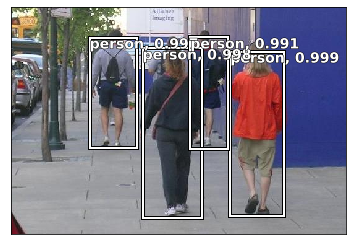

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects


print(prediction[0]) # dict_keys(['boxes', 'labels', 'scores', 'masks'])
result = prediction[0]

print(type(img))
toimg = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
ax = show_img(toimg, figsize=(6, 6)) 
threshold = 0.8
for box, score, label in zip(result['boxes'], result['scores'], result['labels']):    
    score = score.item()        
    if score <= threshold :
        break
    box = box.detach().cpu().clone().numpy()
    b = bb_hw(box)
    draw_rect(ax, b)
    resultscore = "{}, {:1.3f}".format( 'person', score )
    draw_text(ax, b[:2], resultscore )
        
#plt.show()        

In [9]:
# Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
# #img


In [10]:
# COLORS = np.array([
#     (0, 0, 0),       # 0=background
#     (255, 0, 0),     # 1=aeroplane
#     (0, 255, 0),     # 2=bicycle
#     (128, 128, 0),   # 3=bird
#     (0, 0, 128),     # 4=boat
#     (128, 0, 128),   # 5=bottle
#     (0, 128, 128),   # 6=bus
#     (128, 128, 128), # 7=car
#     (255, 255, 255), # 8=cat
#     (192, 0, 0),     # 9=chair
#     (64, 128, 0),    # 10=cow
#     (192, 128, 0),   # 11=dining table
#     (64, 0, 128),    # 12=dog
#     (192, 0, 128),   # 13=horse
#     (64, 128, 128),  # 14=motorbike
#     (192, 128, 128), # 15=person
#     (0, 64, 0),      # 16=potted plant
#     (128, 64, 0),    # 17=sheep
#     (0, 192, 0),     # 18=sofa
#     (128, 192, 0),   # 19=train
#     (0, 64, 128)     # 20=tv/monitor
# ])

In [11]:
# def seg_map(img, n_classes=21):
#     rgb = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
#     for c in range(n_classes):
#         idx = img == c
#         rgb[idx] = COLORS[c]
#     return rgb

In [12]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import matplotlib.patheffects as patheffects

# testimg = Image.open('D:/____Download/FudanPed00001_mask.png')

# np_im = np.array(testimg)
# out_seg = seg_map(np_im)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
# ax[0].imshow(testimg)
# ax[1].imshow(out_seg)